# 機械学習モデルの評価・ハイパーパラメータチューニング

参考文献 (書籍): 
 * Python 機械学習プログラミング 達人データサイエンティストによる理論と実践 
 * Pythonではじめる機械学習 ―scikit-learnで学ぶ特徴量エンジニアリングと機械学習の基礎

In [6]:
# Wisconsin乳がんデータをロードする
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

loaded_data = load_breast_cancer()

# 特徴量をロード
data = loaded_data.data

# 陰性か陽性かのクラス変数 (0 or 1)
target = loaded_data.target

# 上記データを使って、モデリングデータ80%, 検証データ20%に分割する。
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state=1)

"""
1: StandardScalerで標準化する
2: PCA: 主成分分析で2次元まで特徴量を圧縮する
3: ロジスティック回帰で分析する
"""
sample_pipe = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(random_state=1,solver='lbfgs'))

# 上記で作成したパイプラインで学習を行う
sample_pipe.fit(x_train, y_train)

# 
result = sample_pipe.predict(x_test)

# モデルの評価を行う。
score = sample_pipe.score(x_test, y_test)
print(score)
# 0.9473684210526315

0.9473684210526315


In [18]:
from sklearn.model_selection import cross_val_score

# 分割数10, CPU数1で交差検証を実行する。
scores = cross_val_score(estimator=sample_pipe, X=x_train, y=y_train, cv=10, n_jobs=1)
print(scores)

[0.91304348 0.97826087 0.97826087 0.91304348 0.93478261 0.97777778
 0.93333333 0.95555556 0.97777778 0.95555556]


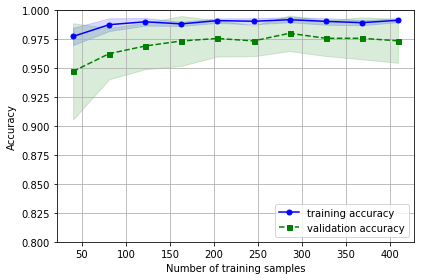

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


pipe = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=1,solver='lbfgs'))

# learning_curve関数で交差検証による正解率を算出する
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe, X=x_train,y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10,n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color="blue", marker="o", markersize=5, label="training accuracy")
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color="blue")
plt.plot(train_sizes, test_mean, color="green", linestyle="--", marker="s",markersize=5,label="validation accuracy")
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color="green")

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()


# 検証曲線で過学習 or 学習不足かを調べる

検証曲線を使って、モデルの過学習や学習不足といった問題を調べることができる。

検証曲線では「モデルのパラメータの値を変化させる」

以下ではロジスティック回帰の逆正則化パラメータであるcを変化させている。



In [5]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1,1.0,10.0,100.0]
"""
validation_curve関数によりモデルのパラメータを変化させ、交差検証による正解率を算出
clf__CはLogisticRegresionオブジェクトのパラメータ
"""

train_scores, test_scores = validation_curve(
    estimator=pipe,
    X=x_train,
    y=y_train,
    param_name="logisticregression__C",
    param_range=param_range,
    cv=10
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(
    param_range,
    train_mean,
    color="blue",
    marker="o",
    markersize=5,
    label="training accuracy"
)


plt.fill_between(
    param_range,
    train_mean + train_std,
    train_mean - train_std,
    alpha=0.15,
    color="blue"
)

plt.plot(
    param_range,
    test_mean,
    color="green",
    linestyle="--",
    marker="s",
    markersize=5,
    label="validation accuracy"
)

plt.fill_between(
    param_range,
    test_mean + test_std,
    test_mean -test_std,
    alpha=0.15,
    color="green"
)

plt.grid()
plt.xscale('log')
plt.legend(loc="lower right")
plt.xlabel("Parameter C")
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()




NameError: ignored

Cの値を小さくして、正則化の強さを上げると、モデルが学習不足気味になっている。
Cの値を大きくして、正則化の強さを下げると、モデルが過学習気味になっている。

C=0.01〜0.1あたりが最適と推定される。

# グリッドサーチによるモデルのチューニング

ハイパーパラメータのチューニングを**グリッドサーチ**で行う。


グリッドサーチは網羅的に探索を行い、複数のハイパーパラメータの値から構成されるリストを指定すると、それらでモデルの性能を評価して、最適な値の組み合わせを捜す。




In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe = make_pipeline(StandardScaler(), SVC(random_state=5))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {"svc__C": param_range, 'svc__kernel': ['linear']},
    {"svc__C": param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}
]

# ハイパーパラメータ値のリスト param_gridを指定して、GridSearchCVをインスタンス化する。
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    n_jobs=-1
)

gs.fit(x_train, y_train)
print("ベストスコア")
print(gs.best_score_)
print("============")
print("ベストなハイパーパラメータ")
print(gs.best_params_)
print("============")

"""
調査結果後のベストな推定器をGridSearchCVから取り出す。
学習させて、推定する
"""
best_estimator = gs.best_estimator_
best_estimator.fit(x_train, y_train)
print("スコアリング結果")
print(best_estimator.score(x_test, y_test))



ベストスコア
0.978021978021978
ベストなハイパーパラメータ
{'svc__C': 0.1, 'svc__kernel': 'linear'}
スコアリング結果
0.9649122807017544


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


上記ではサポートベクターマシンのパイプラインのトレーニングとチューニングをグリッドサーチを使って実施している。

チューニングしたいパラメータを指定するには、GridSearchCVの*param_grid*に対して候補を指定する。

# nested cross-validationで複数の機械学習アルゴリズムからベストなアルゴリズムを選択する

SVMと決定木を比較する。

In [11]:
import numpy as np
from sklearn.model_selection import cross_val_score

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=2
)

scores = cross_val_score(gs, x_train, y_train, scoring="accuracy", cv=5)
print("SVMスコア-------")
print(np.mean(scores))
print(np.std(scores))


from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=0),
    param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
    scoring="accuracy",
    cv=2
)

scores = cross_val_score(
    gs,
    x_train,
    y_train,
    scoring="accuracy",
    cv=5
)
print("決定木スコア-------")
print(np.mean(scores))
print(np.std(scores))


SVMスコア-------
0.9626373626373625
0.026556144996911134
決定木スコア-------
0.9296703296703297
0.028316700498297005


# 性能評価指標

* 混同行列
  * 真陽性 (TP)
  * 真陰性 (TN)
  * 偽陽性 (FP)
  * 偽陰性 (FN)


In [13]:
from sklearn.metrics import confusion_matrix

pipe.fit(x_train, y_train)
predicted = pipe.predict(x_test)
print(confusion_matrix(y_true=y_test, y_pred=predicted))

array([[40,  2],
       [ 1, 71]])


### 正解率

$$
  \frac{TP + TN}{TP + TN + FP + FN}
$$


### 適合率

$$
  \frac{TP}{TP + FP}
$$


### 再現率

$$
  \frac{TP}{TP + FN}
$$

### F1スコア

$$
  2 × \frac{適合率 × 再現率}{適合率 + 再現率}
$$

In [17]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('適合率: %.3f' % precision_score(y_test, predicted))
print('再現率: %.3f' % recall_score(y_test, predicted))
print('F1スコア: %.3f' % f1_score(y_test, predicted))

適合率: 0.973
再現率: 0.986
F1: 0.979


# ROC曲線

受信者操作特性 (Receiver Operating Characteristic)曲線は性能に基づいて、分類モデルを選択するための便利ツール。




In [0]:
from sklearn.metrics import roc_curvem, auc
from scipy import interp

pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression(penalty='l2', random_state=1. C=100)
)

x_train2 = x_train[:, 4,14]
cv = list(S)
